<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Network_Base_Model_separate_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 7.1 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit
from sklearn.metrics import confusion_matrix

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2 = ['AIT201', 'AIT202','AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3 = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4 = ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5 = ['AIT501', 'AIT502', 'AIT503', 'AIT504','FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503']
P6 = ['FIT601', 'P601', 'P602', 'P603']

Model Prediction on each stage

In [15]:
from  pyod.models.deep_svdd import DeepSVDD
model = DeepSVDD(preprocessing = False,epochs=100, batch_size=64, hidden_neurons=[64, 32])

In [16]:
def get_test_score(stage,train_scale,test_scale):
  norm_test_scores = []
  test_scores = []
  train_scores = []
  norm_train_scores = []
  trainning_time = []
  prediction_time = []

  for i in stage:
    start = timeit.default_timer()
    model.fit(train_scale[i])
    end = timeit.default_timer()

    train_score = model.decision_scores_
    start_pred = timeit.default_timer()
    test_score = model.decision_function(test_scale[i])
    end_pred = timeit.default_timer()

    test_scores.append(test_score)
    train_scores.append(train_score)

    trainning_time.append(end-start)
    prediction_time.append(end_pred-start_pred)

    #normalise train&test score
    min_train = min(train_score)
    max_train = max(train_score)
    norm_train = (train_score-min_train)/(max_train-min_train)
    norm_test = (test_score - min_train)/(max_train-min_train)

    norm_test_scores.append(norm_test)
    norm_train_scores.append(norm_train)

    print(f"------ Finish Stage {i} ------")
  return norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time


In [17]:
stage = [P1,P2,P3,P4,P5,P6]

In [18]:
norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time = get_test_score(stage,train_scale,test_scale)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_1 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_1 (TFOpL  (None,)                  0         
 ambda)                                                    

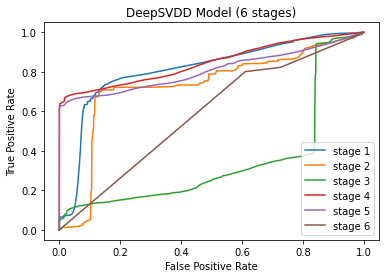

In [19]:
aucs = []
for i in range(len(norm_test_scores)):
  fpr, tpr, _ = metrics.roc_curve(label,  test_scores[i])
  auc = metrics.roc_auc_score(label,  test_scores[i])
  aucs.append(auc)
  plt.plot(fpr,tpr,label=f"stage {i+1}")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'DeepSVDD Model (6 stages)')
  plt.legend(loc=4)

In [20]:
for i in range(len(aucs)):
  print(f"AUC stage{i+1}: {np.round(aucs[i],3)}, training time = {trainning_time[i]}, prediction_time = {prediction_time[i]}")

AUC stage1: 0.813, training time = 1433.477891167, prediction_time = 15.885858706000135
AUC stage2: 0.728, training time = 1366.3430925080002, prediction_time = 16.188696763999815
AUC stage3: 0.346, training time = 1388.3268618370003, prediction_time = 16.006706151999424
AUC stage4: 0.846, training time = 1410.6166519090002, prediction_time = 16.447411797999848
AUC stage5: 0.807, training time = 1474.6116891800002, prediction_time = 16.308685479000815
AUC stage6: 0.587, training time = 1523.2404585400009, prediction_time = 16.192112132999682


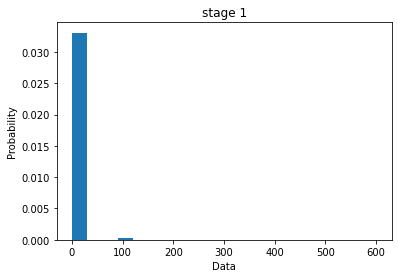

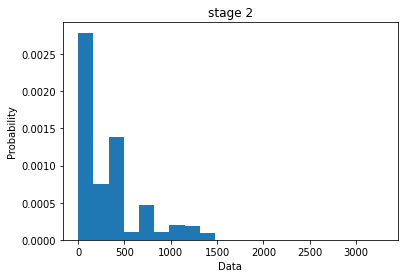

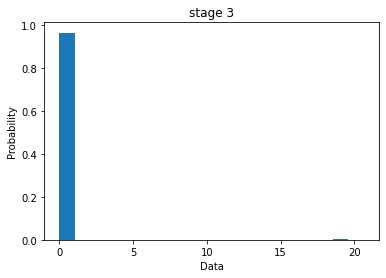

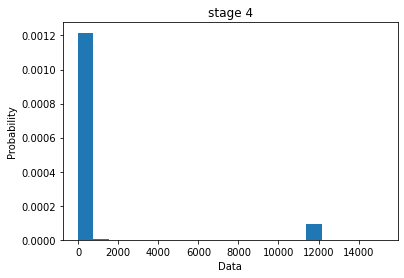

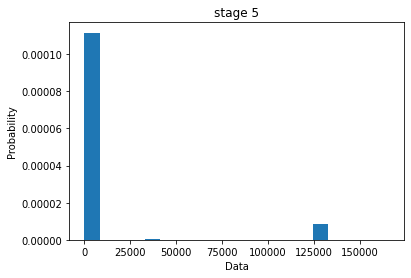

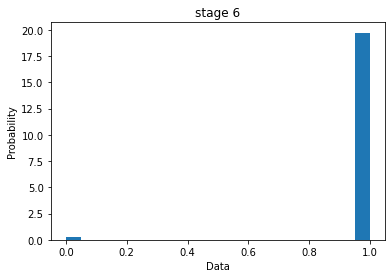

In [21]:
for i in range(len(norm_test_scores)):
  plt.hist(norm_test_scores[i], density=True, bins=20)  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.title(f'stage {i+1}')
  plt.show()

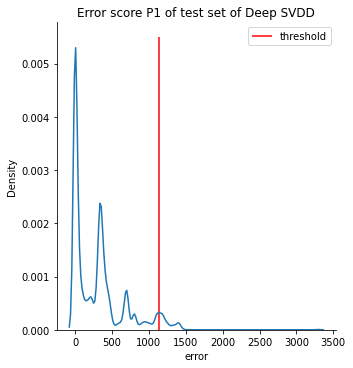

In [146]:
df_score_1 = pd.DataFrame(norm_test_scores[0],columns = ['error'])
sns.displot(df_score_1, x="error",kind="kde")
plt.title("Error score P1 of test set of Deep SVDD")
plt.vlines(np.percentile(norm_test_scores[0],95), ymin = 0, ymax=0.0055,color='red',label="threshold")
plt.legend()
plt.show()

In [23]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
    else:
      pred_label[i:i+time_window] = 0

  return pred_label

In [24]:
time_window = 1

##Ture Attack point

In [25]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [26]:
true_attack = true_anomaly[~true_anomaly["End Time"].isnull()]

In [27]:
true_attack.tail(3)

Attack #          Start Time  End Time      Attack Point  \
38       39  2/01/2015 11:43:48  11:50:28  FIT-401, AIT-502   
39       40  2/01/2015 11:51:42  11:56:38           FIT-401   
40       41  2/01/2015 13:13:02  13:40:56           LIT-301   

                    Start State  \
38              In Normal Range   
39              In Normal Range   
40  Water level between L and H   

                                               Attack Actual Change  \
38  Set value of FIT-401 as 0.5; Set value of AIT-...            No   
39                          Set value of FIT-401 as 0            No   
40                decrease value by 0.5 mm per second            No   

           Expected Impact or attacker intent  \
38  UV will shut down and water will go to RO   
39  UV will shut down and water will go to RO   
40                              Tank overflow   

                                   Unexpected Outcome  
38                                UV did not shutdown  
39    P-402 did not close, both should be interlinked  
40  Rate of decrease in water level reduced after ...

In [28]:
start_time = true_attack['Start Time']
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [29]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [30]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [31]:
len(start_time) #there are 36 attack

36

In [32]:
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [33]:
time_label = pd.DataFrame(label, index =  test_df.index.values, columns = ["label"])
time_label.reset_index(inplace=True)
time_label.rename(columns = {'index':'Timestamp'}, inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label['Timestamp'])

In [34]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [35]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]+1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##tunning threshold from stage P1

In [36]:
!pip install ghostml --quiet

In [37]:
import ghostml
n_percentile = [np.percentile(norm_test_scores,i) for i in range(95,100,1)]

In [38]:
threshold1 = ghostml.optimize_threshold_from_predictions(label, norm_test_scores[0], n_percentile, ThOpt_metrics = 'Kappa') 

In [39]:
threshold1

695.8931884765625

In [40]:
n_percentile #percentil 95

[695.8931884765625,
 913.8966674804688,
 1199.1610107421875,
 11446.880097656249,
 126820.28125]

##Stage P1

In [149]:
t1 = np.percentile(norm_test_scores[0],95)

In [150]:
label_1 = pred_labels_timewindow(norm_test_scores[0],t1,time_window)

In [151]:
time_label["pred_1"] = label_1

In [152]:
att_p1 = time_label[time_label['attack #'].isin([1,2,3,21,26,30,33,34,35,36])]

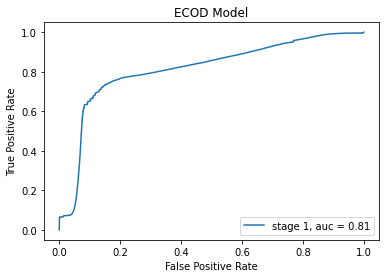

In [153]:
fpr, tpr, _ = metrics.roc_curve(label, norm_test_scores[0])
auc = metrics.roc_auc_score(label, norm_test_scores[0])
plt.plot(fpr,tpr,label=f"stage 1, auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

In [154]:
print(metrics.classification_report(label,label_1))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    395298
           1       0.41      0.07      0.12     54621

    accuracy                           0.87    449919
   macro avg       0.65      0.53      0.52    449919
weighted avg       0.83      0.87      0.83    449919



[[389981   5317]
 [ 50928   3693]]


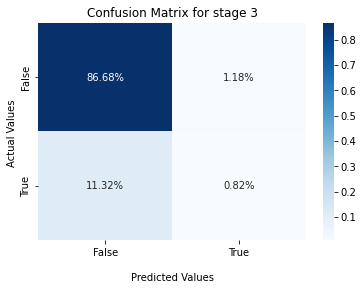

In [155]:
cm = confusion_matrix(label,label_1)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [156]:
print(metrics.classification_report(att_p1.label,att_p1.pred_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70      6669

    accuracy                           0.54      6669
   macro avg       0.50      0.27      0.35      6669
weighted avg       1.00      0.54      0.70      6669



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [157]:
found = []
for i in range(len(att_p1)):
  if (att_p1.iloc[i]["pred_1"] == 1) & (att_p1.iloc[i]["label"] == 1):
    found.append(att_p1.iloc[i]["attack #"])
print(np.unique(found))

[ 1  2  3 26 30 33 34 36]


In [158]:
np.unique(att_p1["attack #"])

array([ 1,  2,  3, 21, 26, 30, 33, 34, 35, 36])

##Stage P2

In [159]:
t2 = np.percentile(norm_test_scores[1],95)

In [160]:
t2

1258.6656494140625

In [161]:
label_2 = pred_labels_timewindow(norm_test_scores[1],t2,time_window)

In [162]:
print(metrics.classification_report(label,label_2))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    395298
           1       0.08      0.01      0.02     54621

    accuracy                           0.86    449919
   macro avg       0.48      0.50      0.47    449919
weighted avg       0.78      0.86      0.82    449919



[[386975   8323]
 [ 53944    677]]


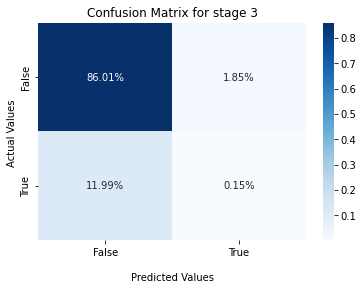

In [163]:
cm = confusion_matrix(label,label_2)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [164]:
time_label["pred_2"] = label_2

In [165]:
att_p2 = time_label[time_label['attack #'].isin([6,24,29])]

In [166]:
found = []
for i in range(len(att_p2)):
  if (att_p2.iloc[i]["pred_2"] == 1) & (att_p2.iloc[i]["label"] == 1):
    found.append(att_p2.iloc[i]["attack #"])
print(np.unique(found))

[6]


In [167]:
print(metrics.classification_report(att_p2.label,att_p2.pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.28      0.43       638

    accuracy                           0.28       638
   macro avg       0.50      0.14      0.22       638
weighted avg       1.00      0.28      0.43       638



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P3

In [168]:
t3 = np.percentile(norm_test_scores[2],95)

In [169]:
t3

0.044402501434087756

In [170]:
label_3 = pred_labels_timewindow(norm_test_scores[2],t3,time_window)

In [171]:
print(metrics.classification_report(label,label_3))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    395298
           1       0.37      0.06      0.10     54621

    accuracy                           0.87    449919
   macro avg       0.62      0.52      0.52    449919
weighted avg       0.82      0.87      0.83    449919



[[389591   5707]
 [ 51329   3292]]


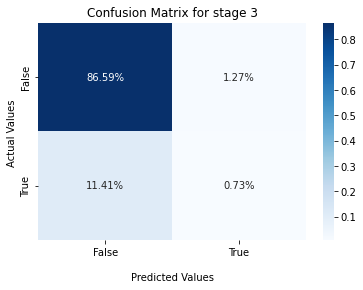

In [172]:
cm = confusion_matrix(label,label_3)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [173]:
time_label["pred_3"] = label_3

In [174]:
att_p3 = time_label[time_label['attack #'].isin([7,8,13,14,16,17,23,26,27,28,32,41])]

In [175]:
found = []
for i in range(len(att_p3)):
  if (att_p3.iloc[i]["pred_3"] == 1) & (att_p3.iloc[i]["label"] == 1):
    found.append(att_p3.iloc[i]["attack #"])
print(np.unique(found))

[ 7  8 14 16 17 23 26 28 41]


In [176]:
print(metrics.classification_report(att_p3.label,att_p3.pred_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.07      0.13     43368

    accuracy                           0.07     43368
   macro avg       0.50      0.03      0.06     43368
weighted avg       1.00      0.07      0.13     43368



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P4

In [177]:
t4 = np.percentile(norm_test_scores[3],95)

In [178]:
t4

11470.9233203125

In [179]:
label_4 = pred_labels_timewindow(norm_test_scores[3],t4,time_window)

In [180]:
print(metrics.classification_report(label,label_4))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    395298
           1       0.99      0.16      0.28     54621

    accuracy                           0.90    449919
   macro avg       0.94      0.58      0.61    449919
weighted avg       0.91      0.90      0.86    449919



[[395195    103]
 [ 45725   8896]]


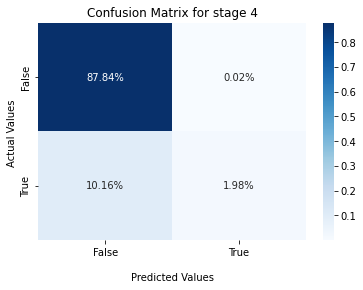

In [181]:
cm = confusion_matrix(label,label_4)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 4');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [182]:
time_label["pred_4"] = label_4

In [183]:
att_p4 = time_label[time_label['attack #'].isin([10,11,22,25,31,38,39,40])]

In [184]:
found = []
for i in range(len(att_p4)):
  if (att_p4.iloc[i]["pred_4"] == 1) & (att_p4.iloc[i]["label"] == 1):
    found.append(att_p4.iloc[i]["attack #"])
print(np.unique(found))

[10 11 40]


In [185]:
print(metrics.classification_report(att_p4.label,att_p4.pred_4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.26      0.41      3142

    accuracy                           0.26      3142
   macro avg       0.50      0.13      0.21      3142
weighted avg       1.00      0.26      0.41      3142



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P5

In [186]:
t5 = np.percentile(norm_test_scores[4],95)

In [187]:
t5

128924.625

In [188]:
label_5 = pred_labels_timewindow(norm_test_scores[4],t5,time_window)

In [189]:
print(metrics.classification_report(label,label_5))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95    395298
           1       0.99      0.16      0.28     54621

    accuracy                           0.90    449919
   macro avg       0.94      0.58      0.61    449919
weighted avg       0.91      0.90      0.86    449919



[[395218     80]
 [ 45681   8940]]


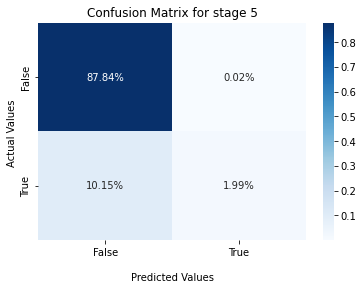

In [190]:
cm = confusion_matrix(label,label_5)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 5');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [191]:
time_label["pred_5"] = label_5

In [192]:
att_p5 = time_label[time_label['attack #'].isin([4,19,20,22,37,38,39])]

In [193]:
found = []
for i in range(len(att_p5)):
  if (att_p5.iloc[i]["pred_5"] == 1) & (att_p5.iloc[i]["label"] == 1):
    found.append(att_p5.iloc[i]["attack #"])
print(np.unique(found))

[]


In [194]:
print(metrics.classification_report(att_p5.label,att_p5.pred_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    2658.0

    accuracy                           0.00    2658.0
   macro avg       0.00      0.00      0.00    2658.0
weighted avg       0.00      0.00      0.00    2658.0



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


##Stage P6

due to most of the data has very high error score, we use lower bound instead

In [87]:
pd.DataFrame(norm_test_scores[5]).describe()

0
count  4.499190e+05
mean   9.878163e-01
std    1.065291e-01
min    4.054336e-07
25%    9.998308e-01
50%    1.000000e+00
75%    1.000000e+00
max    1.000000e+00

In [88]:
t6 = np.percentile(norm_test_scores[5],25)

In [89]:
t6

0.9998307824134827

In [90]:
label_6 = np.where(norm_test_scores[5] < t6, 1,0)

In [91]:
print(metrics.classification_report(label,label_6))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92    395298
           1       0.10      0.02      0.04     54621

    accuracy                           0.85    449919
   macro avg       0.49      0.50      0.48    449919
weighted avg       0.78      0.85      0.81    449919



[[383369  11929]
 [ 53364   1257]]


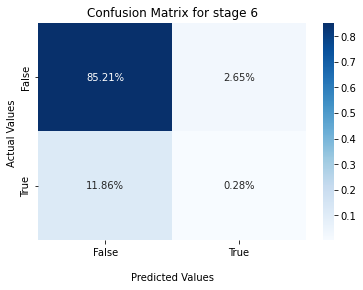

In [92]:
cm = confusion_matrix(label,label_6)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 6');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [93]:
time_label["pred_6"] = label_6

In [94]:
att_p6 = time_label[time_label['attack #'].isin([23])]

In [95]:
found = []
for i in range(len(att_p6)):
  if (att_p6.iloc[i]["pred_6"] == 1) & (att_p6.iloc[i]["label"] == 1):
    found.append(att_p6.iloc[i]["attack #"])
print(np.unique(found))

[23]


In [96]:
print(metrics.classification_report(att_p6.label,att_p6.pred_6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.06       697

    accuracy                           0.03       697
   macro avg       0.50      0.02      0.03       697
weighted avg       1.00      0.03      0.06       697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0]
 [674  23]]


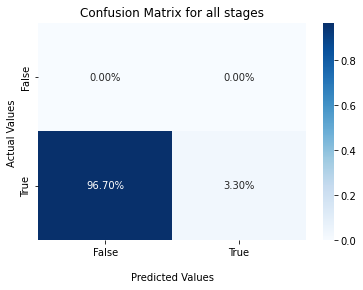

In [97]:
cm = confusion_matrix(att_p6.label,att_p6.pred_6)

print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

##Attack found

In [196]:
time_label['pred'] = np.where((time_label['pred_1'] ==1) | 
                              (time_label['pred_2'] ==1) |
                              (time_label['pred_3'] ==1) |
                              (time_label['pred_4'] ==1) |
                              (time_label['pred_5'] ==1) |
                              (time_label['pred_6'] ==1), 1, 0)


In [207]:
time_label[time_label["label"] == 1].tail(5)

Timestamp  label  attack #  pred_1  pred_2  pred_3  pred_4  \
445186 2016-02-01 13:41:07      1         0       0       0       1       0   
445187 2016-02-01 13:41:08      1         0       0       0       1       0   
445188 2016-02-01 13:41:09      1         0       0       0       1       0   
445189 2016-02-01 13:41:10      1         0       0       0       1       0   
445190 2016-02-01 13:41:11      1         0       0       0       1       0   

        pred_5  pred_6  pred  found  
445186       0       0     1      1  
445187       0       0     1      1  
445188       0       0     1      1  
445189       0       0     1      1  
445190       0       0     1      1

In [200]:
time_label['found'] = 0
t = 100
for i in range(0,len(time_label)-t):
  if ((time_label['pred'][i:i+t]) == 1).all():
    time_label['found'][i:i+t] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [198]:
found = []
for i in range(len(time_label)):
  if (time_label.iloc[i]["found"] == 1) & (time_label.iloc[i]["label"] == 1):
    found.append(time_label.iloc[i]["attack #"])
print(np.unique(found))

[ 0  1  2  3  6  7  8 10 11 14 16 17 19 21 23 24 25 26 27 28 30 31 33 34
 35 36 37 38 40 41]


In [199]:
len(np.unique(found))-1 #remove 0

29

In [203]:
print(metrics.classification_report(time_label.label,time_label.found))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    395298
           1       0.60      0.42      0.49     54621

    accuracy                           0.90    449919
   macro avg       0.76      0.69      0.72    449919
weighted avg       0.88      0.90      0.89    449919



In [204]:
cm = confusion_matrix(time_label.label,time_label.found)

print(cm)

[[379642  15656]
 [ 31577  23044]]


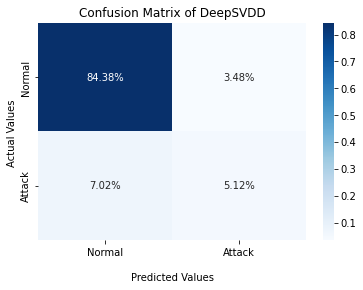

In [311]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix of DeepSVDD');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Attack'])
ax.yaxis.set_ticklabels(['Normal','Attack'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [209]:
att_found = np.unique(found)[1:]
att_found

array([ 1,  2,  3,  6,  7,  8, 10, 11, 14, 16, 17, 19, 21, 23, 24, 25, 26,
       27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41])

###Find explanation for un-detected attack

In [ ]:
#att no.4 happend in process 5
id_a = 3
t_add = 300
att_score = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P1')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score), label=f'Threshold at {np.round(t1,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['MV504'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='MV504')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.4")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+11), [-0.05,0.3]*(420//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

In [296]:
test_scale.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

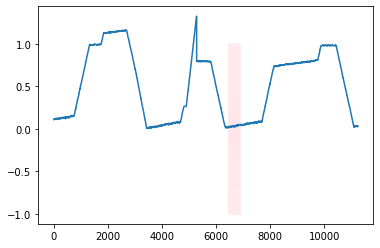

In [288]:
plt.plot(np.arange(len(test_scale['LIT101'])//40),test_scale['LIT101'][:len(test_scale['LIT101'])//40])
plt.fill_between(np.arange(idx_start[3]-20,idx_end[3]+11), [-1,1]*(420//2), alpha=0.3, 
                 color = 'pink')

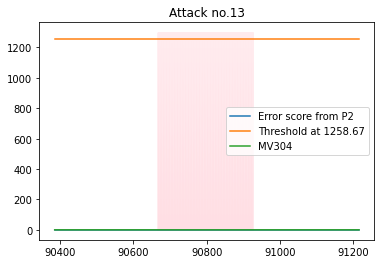

In [298]:
#att no.13 happend in process 2
id_a = 9
t_add = 300
att_score = norm_test_scores[1][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(6,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P2')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t2]*len(att_score), label=f'Threshold at {np.round(t2,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['MV304'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='MV304')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.13")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0.05,1300]*(262//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

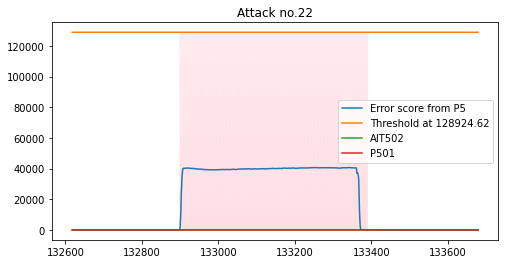

In [247]:
#att no.22 happend in process 4,5
id_a = 16
t_add = 300
# att_score = norm_test_scores[3][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
att_score2 = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]


plt.figure(figsize=(8,4))
# plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P4')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score2, label='Error score from P5')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score), label=f'Threshold at {np.round(t5,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT502'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='AIT502')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['P501'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='P501')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.22")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0,t5+1]*(492//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

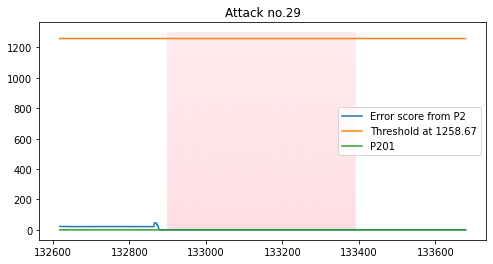

In [252]:
#att no.29 happend in process 2
id_a = 16
t_add = 300
att_score = norm_test_scores[1][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P2')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t2]*len(att_score), label=f'Threshold at {np.round(t2,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['P201'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='P201')
plt.title("Attack no.29")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0.05,1300]*(492//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

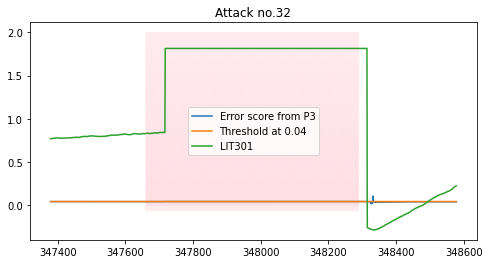

In [261]:
#att no.32 happend in process 3
id_a = 26
t_add = 300
att_score = norm_test_scores[2][idx_start[id_a]-t_add:idx_end[id_a]+t_add]

plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P3')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t3]*len(att_score), label=f'Threshold at {np.round(t3,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['LIT301'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='LIT301')
plt.title("Attack no.32")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0.05,2]*(630//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

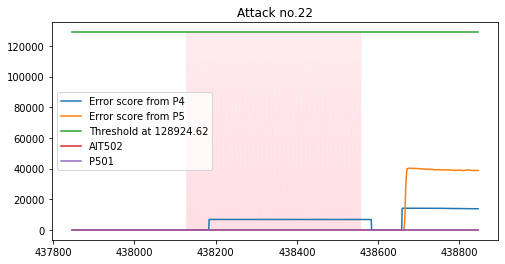

In [268]:
#att no.39 happend in process 2
id_a = 33
t_add = 300
att_score = norm_test_scores[3][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
att_score2 = norm_test_scores[4][idx_start[id_a]-t_add:idx_end[id_a]+t_add]


plt.figure(figsize=(8,4))
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score, label='Error score from P4')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add),att_score2, label='Error score from P5')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), [t5]*len(att_score), label=f'Threshold at {np.round(t5,2)}')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['FIT401'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='AIT502')
plt.plot(np.arange(idx_start[id_a]-t_add,idx_end[id_a]+t_add), test_scale['AIT502'][idx_start[id_a]-t_add:idx_end[id_a]+t_add]
         , label='P501')
# plt.vlines(idx_start[id_a], ymin=-0.5, ymax=0.8)
# plt.vlines(idx_end[id_a], ymin=-0.5, ymax=0.8)
plt.title("Attack no.22")
plt.fill_between(np.arange(idx_start[id_a]-20,idx_end[id_a]+10), [-0,t5+1]*(430//2), alpha=0.3, 
                 color = 'pink')
plt.legend()

#XAI

In [106]:
!pip install shap --quiet
!pip install lime --quiet
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 569 kB 7.1 MB/s 
     |████████████████████████████████| 275 kB 8.1 MB/s 
     |████████████████████████████████| 445 kB 8.4 MB/s 
     |████████████████████████████████| 60 kB 8.1 MB/s 
     |████████████████████████████████| 4.7 MB 56.7 MB/s 
     |████████████████████████████████| 98.5 MB 1.2 MB/s 
     |████████████████████████████████| 6.6 MB 59.2 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 


In [107]:
import shap
import lime
import lime.lime_tabular
from lime import submodular_pick
from alibi.explainers import ALE
from alibi.explainers import IntegratedGradients

In [ ]:
X_train_summary = shap.kmeans(train_scale, 100)

In [125]:
print(model.decision_function)

<bound method DeepSVDD.decision_function of DeepSVDD(batch_size=64,
     c=array([0.14351, 0.     , 0.1775 , 0.1    , 0.1    , 0.     , 0.     ,
       0.1    , 0.1    , 0.     , 0.1    , 0.1    , 0.1    , 0.     ,
       0.13826, 0.1    , 0.1    , 0.     , 0.     , 0.37501, 0.37783,
       0.1    , 0.27106, 0.20794, 0.     , 0.1    , 0.1    , 0.27419,
       0.18227, 0.1    , 0.     , 0.1    ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=100,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=False,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)>


In [148]:
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary)

In [131]:
ale = ALE(model.decision_function, feature_names=train_scale.columns)
lm = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

## case study att no.24
P203,P205 are attack point

In [305]:
idx = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == 24)].index.values
n = 100 if len(idx) > 100 else len(idx)
sample = test_scale[idx[0]:idx[-1]].sample(n = n)

In [306]:
shap_value = shap_explainer.shap_values(X=sample, nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

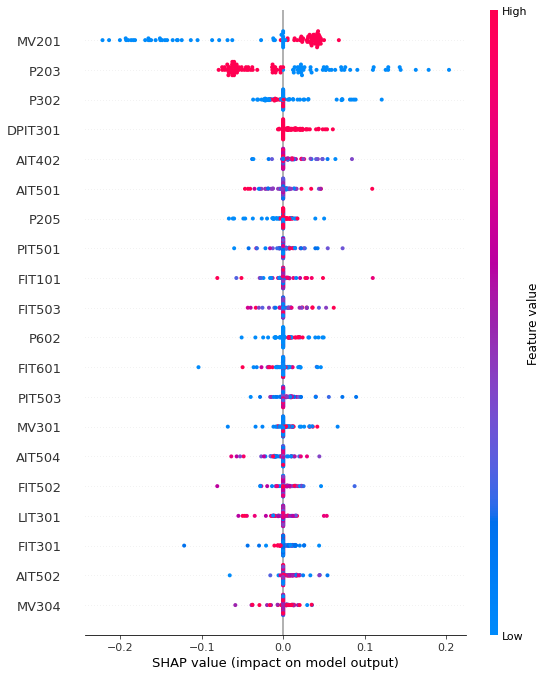

In [307]:
shap.initjs()
shap.summary_plot(shap_value, sample)

Requested sample size larger than
                              size of input data. Using all data


Intercept 0.21647278775143824
Prediction_local [0.09536414]
Right: 0.024310477
Intercept 0.17827191805801065
Prediction_local [0.12077081]
Right: 0.019416042
Intercept 0.1275681650003924
Prediction_local [0.1352279]
Right: 0.015683146
Intercept 0.21065639958505888
Prediction_local [0.08392901]
Right: 0.004950449
Intercept 0.22412378533025204
Prediction_local [0.06725913]
Right: 0.021025531
Intercept 0.1610703825865073
Prediction_local [0.12106642]
Right: 0.021836769
Intercept 0.19020264677418983
Prediction_local [0.11228837]
Right: 0.027171465
Intercept 0.1580617557598103
Prediction_local [0.16112966]
Right: 0.017554197
Intercept 0.1154732982414884
Prediction_local [0.13850737]
Right: 0.0068744523
Intercept 0.1508595947042713
Prediction_local [0.14584689]
Right: 0.023152545
Intercept 0.16322329848288003
Prediction_local [0.14615596]
Right: 0.019826384
Intercept 0.09831631777931626
Prediction_local [0.23213573]
Right: 0.030499108
Intercept 0.057317773207184244
Prediction_local [0.232582

[<Figure size 432x288 with 1 Axes>]

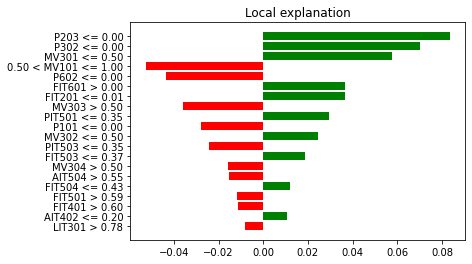

In [308]:
sp_obj = submodular_pick.SubmodularPick(lm, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]

Text(0.5, 0, 'feature')

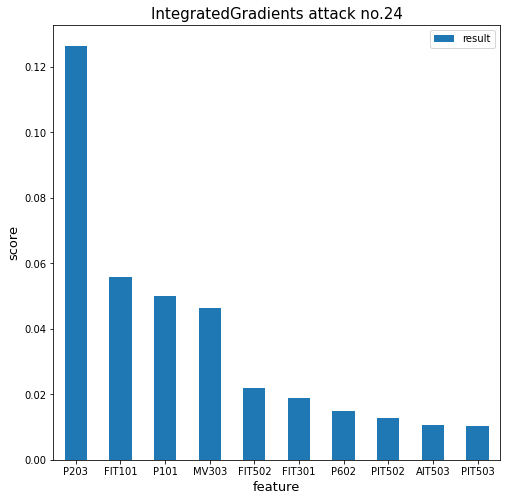

In [319]:
ig  = IntegratedGradients(model.model_,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)
ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[1]*len(sample))
attributions = ig_explanation.attributions
ig_result = pd.DataFrame(np.mean(attributions[0],axis=0), index= train_scale.columns, columns = ["result"])
ig_plot = ig_result.sort_values(by = ["result"], ascending=False)[0:10]
ig_plot.plot.bar(rot=0,figsize=(8, 8))
plt.title("IntegratedGradients attack no.24",size=15)
plt.ylabel("score",size=13)
plt.xlabel("feature",size=13)

In [320]:
exp_ale = ale.explain(sample.to_numpy())

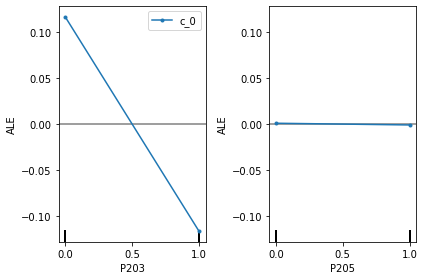

In [323]:
from alibi.explainers import plot_ale
plot_ale(exp_ale, features = ['P203','P205']);

##find all explaination for anomaly detected

In [324]:
def explain_all_attack(att_found,test_scale):
  shap_values = []
  limes = []
  ales = []
  igs = []
  for i in att_found:
    idx = time_label[(time_label["attack #"] == i)].index.values
    n = 100 if len(idx) > 100 else len(idx)
    sample = test_scale[idx[0]:idx[-1]].sample(n = n)
    #shap explainer
    shap_value = shap_explainer.shap_values(X=sample, nsamples=100)
    shap_values.append(np.mean(shap_value,axis=0))

    #lime
    sp_obj = submodular_pick.SubmodularPick(lm, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
    limes.append(sp_obj.sp_explanations[0].as_list())

    #ale
    exp_ale = ale.explain(sample.to_numpy())
    ales.append([np.mean(e) for e in exp_ale.ale_values])

    #IG
    ig_explanation = ig.explain(sample.to_numpy(),
                         baselines=None,
                         target=[0]*len(sample))
    igs.append(np.mean(ig_explanation.attributions[0],axis=0))

    print(f"---------------------------------- finish XAI attack no {i} ----------------------------")
  
  return shap_values,limes,ales,igs

In [325]:
shap_values,limes,ales,igs = explain_all_attack(att_found,test_scale)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.21533220624211435
Prediction_local [0.04957931]
Right: 0.0064633214
Intercept 0.18147666210593513
Prediction_local [0.08066869]
Right: 0.0074727684
Intercept 0.17986051147852294
Prediction_local [0.09737122]
Right: 0.0075641023
Intercept 0.20495306325983303
Prediction_local [0.11211706]
Right: 0.0073064384
Intercept 0.1988568422914146
Prediction_local [0.04866437]
Right: 0.0074202013
Intercept 0.07875146144004544
Prediction_local [0.22143846]
Right: 0.006639933
Intercept 0.18659562449511558
Prediction_local [0.08317577]
Right: 0.0073608262
Intercept 0.19786580890013383
Prediction_local [0.04579052]
Right: 0.0074613416
Intercept 0.14951544909791895
Prediction_local [0.08755374]
Right: 0.0073786313
Intercept 0.18307576651889432
Prediction_local [0.06250841]
Right: 0.0074775694
Intercept 0.15316216256817078
Prediction_local [0.16058624]
Right: 0.00785978
Intercept 0.1353774070866406
Prediction_local [0.13790549]
Right: 0.007057677
Intercept 0.16984215234412114
Prediction_local

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.22262080108633583
Prediction_local [0.32118185]
Right: 0.5896688
Intercept 0.14804513891262175
Prediction_local [0.34659687]
Right: 0.55947435
Intercept 0.11439396517174936
Prediction_local [0.33751034]
Right: 0.5524684
Intercept 0.14297329115584828
Prediction_local [0.33744018]
Right: 0.55702436
Intercept 0.09014336572791395
Prediction_local [0.35379194]
Right: 0.5581673
Intercept 0.11780254163117865
Prediction_local [0.34146297]
Right: 0.54072136
Intercept 0.14667888041779584
Prediction_local [0.34582796]
Right: 0.5876795
Intercept 0.15598284321450281
Prediction_local [0.14028782]
Right: 0.16853306
Intercept 0.16009686793403982
Prediction_local [0.3281376]
Right: 0.53649473
Intercept 0.1555450461760927
Prediction_local [0.33187347]
Right: 0.54173493
Intercept 0.09909074592006717
Prediction_local [0.13682561]
Right: 0.15101442
Intercept 0.1475669085900836
Prediction_local [0.33910191]
Right: 0.5635808
Intercept 0.1656570111983907
Prediction_local [0.339586]
Right: 0.588579

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.024568752445385617
Prediction_local [0.22472963]
Right: 0.0067039803
Intercept 0.07529884438236253
Prediction_local [0.2444657]
Right: 0.0065753553
Intercept 0.021265552787570002
Prediction_local [0.33127764]
Right: 0.006873734
Intercept 0.06713194143356163
Prediction_local [0.23500314]
Right: 0.0065424163
Intercept 0.02400689063500136
Prediction_local [0.33646146]
Right: 0.0067320284
Intercept 0.1087647514946129
Prediction_local [0.17783049]
Right: 0.006800082
Intercept 0.1253568404211172
Prediction_local [0.22269744]
Right: 0.00674997
Intercept 0.1369687396386496
Prediction_local [0.19028683]
Right: 0.0068304036
Intercept 0.12507345425350166
Prediction_local [0.191981]
Right: 0.0066514155
Intercept -0.05799122675088389
Prediction_local [0.31560699]
Right: 0.0070991954
Intercept 0.03601202727856892
Prediction_local [0.25224542]
Right: 0.006589642
Intercept 0.05945508275207868
Prediction_local [0.2383183]
Right: 0.006078594
Intercept -0.01788550710100137
Prediction_local [0

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.08915432062344344
Prediction_local [0.17963568]
Right: 1.4651383
Intercept 0.1036746993122731
Prediction_local [0.14399435]
Right: 1.4281507
Intercept 0.20421390850521315
Prediction_local [0.07963928]
Right: 0.0071648397
Intercept 0.09879752542350262
Prediction_local [0.17116134]
Right: 1.4415447
Intercept 0.11867328075464487
Prediction_local [0.16553615]
Right: 1.428696
Intercept 0.12170584582474928
Prediction_local [0.17810775]
Right: 1.4379647
Intercept 0.1182170392812994
Prediction_local [0.19505976]
Right: 1.4786416
Intercept 0.09057052642313264
Prediction_local [0.18028275]
Right: 1.389277
Intercept 0.09789697789025001
Prediction_local [0.12838874]
Right: 1.3929474
Intercept 0.08932751100041021
Prediction_local [0.18507382]
Right: 1.4178681
Intercept 0.11469653917071493
Prediction_local [0.18809048]
Right: 1.4421464
Intercept 0.14353842131940286
Prediction_local [0.17941192]
Right: 1.4614844
Intercept 0.13822828982687407
Prediction_local [0.16646684]
Right: 1.4418356


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.0962736318329954
Prediction_local [0.1950754]
Right: 0.007318221
Intercept 0.1669318713889383
Prediction_local [0.12154888]
Right: 0.0070439545
Intercept 0.1498103811038039
Prediction_local [0.14314257]
Right: 0.0072128857
Intercept 0.13711159723845065
Prediction_local [0.11801891]
Right: 0.007041842
Intercept 0.13014105351150146
Prediction_local [0.13502127]
Right: 0.0073483177
Intercept 0.1422559316244376
Prediction_local [0.17432981]
Right: 0.0073174685
Intercept 0.1675117845692494
Prediction_local [0.13315657]
Right: 0.0070952205
Intercept 0.14728592683973998
Prediction_local [0.15617872]
Right: 0.0073374016
Intercept 0.17468419714561562
Prediction_local [0.1446997]
Right: 0.0071206056
Intercept 0.17329245213593136
Prediction_local [0.15715701]
Right: 0.007027109
Intercept 0.14199987545092016
Prediction_local [0.14013298]
Right: 0.007102348
Intercept 0.10463645277284556
Prediction_local [0.20187134]
Right: 0.006961108
Intercept 0.08319980123740224
Prediction_local [0.18

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.159495647817836
Prediction_local [0.12671384]
Right: 0.024469875
Intercept 0.0790619339888355
Prediction_local [0.24818237]
Right: 0.021241015
Intercept 0.13384319854268809
Prediction_local [0.18342155]
Right: 0.028334932
Intercept 0.1996071804330405
Prediction_local [0.12540183]
Right: 0.0107501745
Intercept 0.13195025911403105
Prediction_local [0.14261041]
Right: 0.033369206
Intercept 0.14723392650642572
Prediction_local [0.17869903]
Right: 0.0063896966
Intercept 0.0911044875723804
Prediction_local [0.16389348]
Right: 0.019445144
Intercept 0.04156617925325343
Prediction_local [0.26281532]
Right: 0.010223628
Intercept 0.1574563178607242
Prediction_local [0.16194572]
Right: 0.028603032
Intercept 0.11657649722412179
Prediction_local [0.20963908]
Right: 0.018587451
Intercept 0.11419408508714894
Prediction_local [0.17950611]
Right: 0.03159587
Intercept 0.17654242046291083
Prediction_local [0.1174871]
Right: 0.044724673
Intercept 0.06326059867390946
Prediction_local [0.26738914

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept -0.2634021454844427
Prediction_local [1.1740205]
Right: 56.329758
Intercept -10.772623716044565
Prediction_local [34.44444388]
Right: 2010.3346
Intercept -0.28023391052836244
Prediction_local [1.07136911]
Right: 55.7919
Intercept -0.2992381944117444
Prediction_local [1.19189806]
Right: 56.31511
Intercept -0.14702970698237255
Prediction_local [1.15118595]
Right: 55.865646
Intercept -0.2906885899790826
Prediction_local [1.13437655]
Right: 56.166405
Intercept -8.449504506229196
Prediction_local [28.30683359]
Right: 1548.8667
Intercept -0.24398570794831106
Prediction_local [1.07129605]
Right: 55.75165
Intercept -0.276765215284356
Prediction_local [1.18014939]
Right: 55.236145
Intercept -0.2711681435230444
Prediction_local [1.15714866]
Right: 55.674194
Intercept -0.23511145406264192
Prediction_local [1.04481822]
Right: 55.667747
Intercept -0.3003700505373911
Prediction_local [1.16794568]
Right: 55.66726
Intercept -0.26159221031940205
Prediction_local [1.21308171]
Right: 56.050987


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept -9.681328931653278
Prediction_local [32.10682727]
Right: 1783.7063
Intercept -10.082997147747868
Prediction_local [34.12032578]
Right: 1846.6033
Intercept -10.877835854926232
Prediction_local [36.41893638]
Right: 1956.2141
Intercept -9.672694627738915
Prediction_local [32.30090626]
Right: 1775.9568
Intercept -10.308374052231821
Prediction_local [34.45930858]
Right: 1798.8104
Intercept -9.652957237398407
Prediction_local [32.32397469]
Right: 1787.5253
Intercept -10.577389771547475
Prediction_local [35.1777758]
Right: 1935.9331
Intercept -9.74585494173649
Prediction_local [32.74688365]
Right: 1776.0006
Intercept -9.78989852601668
Prediction_local [31.74136]
Right: 1791.4407
Intercept -9.709621504992134
Prediction_local [33.03971673]
Right: 1782.4825
Intercept -5.7403318363605695
Prediction_local [21.8913809]
Right: 1006.0856
Intercept -10.60719979752973
Prediction_local [35.3788506]
Right: 1896.3
Intercept -9.669824889882394
Prediction_local [32.94858057]
Right: 1772.5037
Inter

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.18698168890215833
Prediction_local [0.08089365]
Right: 0.007468231
Intercept 0.18490554524634462
Prediction_local [0.0212248]
Right: 0.007413854
Intercept 0.2520153039120919
Prediction_local [-0.01013805]
Right: 0.0074301045
Intercept 0.14755615101368058
Prediction_local [0.08954425]
Right: 0.0074988687
Intercept 0.16823225972365805
Prediction_local [0.0740554]
Right: 0.0073136305
Intercept 0.19932004831549757
Prediction_local [0.06226399]
Right: 0.0074633867
Intercept 0.177242811968492
Prediction_local [0.06612453]
Right: 0.0075444654
Intercept 0.06066283519495294
Prediction_local [0.22098639]
Right: 0.0068184645
Intercept 0.03080770061521286
Prediction_local [0.25505632]
Right: 0.0066717607
Intercept 0.03796568147622775
Prediction_local [0.2439942]
Right: 0.006750003
Intercept 0.08101029673458676
Prediction_local [0.15316485]
Right: 0.005844798
Intercept 0.19298840039082804
Prediction_local [0.08780857]
Right: 0.007437263
Intercept 0.15515154783693336
Prediction_local [0.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.12770604397113303
Prediction_local [0.13300197]
Right: 0.007596374
Intercept 0.15102625070583647
Prediction_local [0.11797582]
Right: 0.0077381833
Intercept 0.1090894574196945
Prediction_local [0.07836264]
Right: 0.007343062
Intercept 0.1255339693272877
Prediction_local [0.11690349]
Right: 0.007628475
Intercept 0.15265514049023615
Prediction_local [0.14039239]
Right: 0.007517685
Intercept 0.14237776876551236
Prediction_local [0.1120712]
Right: 0.007438588
Intercept 0.1663786466235372
Prediction_local [0.09650544]
Right: 0.0071894145
Intercept 0.15282645476614398
Prediction_local [0.10760275]
Right: 0.007544682
Intercept 0.16062046977464045
Prediction_local [0.08755845]
Right: 0.0074565103
Intercept 0.05872027790244934
Prediction_local [0.18859553]
Right: 0.0063894484
Intercept 0.13447181853341975
Prediction_local [0.10687867]
Right: 0.0071280487
Intercept 0.168644952361731
Prediction_local [0.07059123]
Right: 0.007206068
Intercept 0.1246359523003938
Prediction_local [0.1070

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.09329288422111784
Prediction_local [0.18986479]
Right: 0.009912897
Intercept 0.1807873337039057
Prediction_local [0.08720216]
Right: 0.0073021203
Intercept 0.22034019521876305
Prediction_local [0.04737619]
Right: 0.00741122
Intercept 0.1436866729358326
Prediction_local [0.10932103]
Right: 0.0001401435
Intercept 0.21009864335638323
Prediction_local [0.09466095]
Right: 0.007432976
Intercept 0.1928184447969286
Prediction_local [0.07315747]
Right: 0.0074004624
Intercept 0.18064956209445596
Prediction_local [0.07752521]
Right: 0.00015784605
Intercept 0.19738670238876707
Prediction_local [0.07447729]
Right: 0.0073822904
Intercept 0.14885235265042154
Prediction_local [0.10967611]
Right: 2.8709223e-05
Intercept 0.21686393248703295
Prediction_local [0.07413358]
Right: 0.00726588
Intercept 0.17582670178529258
Prediction_local [0.09650869]
Right: 5.329005e-06
Intercept 0.15130698118210262
Prediction_local [0.13661685]
Right: 4.7054917e-05
Intercept 0.18927793408872018
Prediction_local

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.15639312842292954
Prediction_local [0.15763442]
Right: 0.0040535126
Intercept 0.23002061386903982
Prediction_local [0.07580924]
Right: 2.8693334e-05
Intercept 0.17140626898875921
Prediction_local [0.0937218]
Right: 0.0058492264
Intercept 0.08174312169123903
Prediction_local [0.18055498]
Right: 0.00663771
Intercept 0.09006584859936359
Prediction_local [0.1567874]
Right: 0.005675015
Intercept 0.16457947206742846
Prediction_local [0.13255381]
Right: 0.00487939
Intercept 0.17825968642038054
Prediction_local [0.09099686]
Right: 0.007234554
Intercept 0.2027921544733757
Prediction_local [0.05824046]
Right: 1.5013151e-05
Intercept 0.14321438887365323
Prediction_local [0.15890362]
Right: 0.005155792
Intercept 0.14193858802702655
Prediction_local [0.12439791]
Right: 0.00012796152
Intercept 0.2020814638710454
Prediction_local [0.0890859]
Right: 1.7619279e-05
Intercept 0.14158655079790675
Prediction_local [0.12786509]
Right: 0.00607019
Intercept 0.19113315513928053
Prediction_local [0.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.17549983012288317
Prediction_local [0.10886742]
Right: 0.007746017
Intercept 0.18312597237376987
Prediction_local [0.10012223]
Right: 0.007500491
Intercept 0.24366064028046783
Prediction_local [0.06452967]
Right: 0.007593709
Intercept 0.2189619871952272
Prediction_local [0.10719511]
Right: 0.0076619256
Intercept 0.22936417861929975
Prediction_local [0.05179083]
Right: 0.007892729
Intercept 0.1943930347298563
Prediction_local [0.12108686]
Right: 0.007789127
Intercept 0.14195879057598418
Prediction_local [0.13766219]
Right: 0.007924999
Intercept 0.19248672487582813
Prediction_local [0.06973063]
Right: 0.007813227
Intercept 0.1932188280238022
Prediction_local [0.08065955]
Right: 0.0077496003
Intercept 0.18826252195922266
Prediction_local [0.1261078]
Right: 0.0074174786
Intercept 0.16964060343231754
Prediction_local [0.12443729]
Right: 0.007721492
Intercept 0.1726398828674872
Prediction_local [0.06073917]
Right: 0.0077060675
Intercept 0.1498972474520814
Prediction_local [0.0779

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.08655038394755832
Prediction_local [0.2109448]
Right: 0.06688745
Intercept 0.08018880188328961
Prediction_local [0.23878233]
Right: 0.05371656
Intercept 0.08631198692185059
Prediction_local [0.26845699]
Right: 0.016413597
Intercept 0.08261677970397227
Prediction_local [0.29253748]
Right: 0.056184992
Intercept 0.08722683703170592
Prediction_local [0.20376112]
Right: 0.069530524
Intercept 0.09004856265627877
Prediction_local [0.21988563]
Right: 0.06670563
Intercept 0.07792147837998177
Prediction_local [0.22046596]
Right: 0.0776257
Intercept 0.08141522750068171
Prediction_local [0.21141519]
Right: 0.06834112
Intercept 0.09736074730475071
Prediction_local [0.22019965]
Right: 0.06803959
Intercept 0.08039226815760521
Prediction_local [0.18064719]
Right: 0.06832123
Intercept 0.06675135453654604
Prediction_local [0.25648731]
Right: 0.062422343
Intercept 0.069553297723051
Prediction_local [0.20987995]
Right: 0.06839859
Intercept 0.10027781213899642
Prediction_local [0.21910631]
Righ

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.021636596153205095
Prediction_local [0.2201018]
Right: 0.05615892
Intercept 0.024093102370586733
Prediction_local [0.27825023]
Right: 0.065708205
Intercept 0.05156535430440057
Prediction_local [0.24663517]
Right: 0.05873236
Intercept 0.03550831496801418
Prediction_local [0.22366087]
Right: 0.56621087
Intercept 0.022880353408150353
Prediction_local [0.26471312]
Right: 0.5773662
Intercept 0.03429229440675993
Prediction_local [0.25737153]
Right: 0.055009507
Intercept 0.0497900233332786
Prediction_local [0.2332562]
Right: 0.052458726
Intercept 0.04906676307101768
Prediction_local [0.23544535]
Right: 0.052044608
Intercept 0.028162779720860495
Prediction_local [0.23500851]
Right: 0.05639284
Intercept 0.06298376090359885
Prediction_local [0.23691668]
Right: 0.06527612
Intercept 0.053134984555674725
Prediction_local [0.2956885]
Right: 0.048262753
Intercept 0.06007909131422104
Prediction_local [0.25622726]
Right: 0.05669054
Intercept 0.05039159958052551
Prediction_local [0.23018033]

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.039267633579510686
Prediction_local [0.27805134]
Right: 0.05864202
Intercept -0.011509828761772395
Prediction_local [0.33635123]
Right: 0.051750943
Intercept 0.02328831912182114
Prediction_local [0.25698529]
Right: 0.05459177
Intercept 0.03284429165161548
Prediction_local [0.26964297]
Right: 0.051603895
Intercept 0.00598309606562214
Prediction_local [0.29355759]
Right: 0.058567327
Intercept -0.04380990152328351
Prediction_local [0.30750403]
Right: 0.05222153
Intercept -0.008963885252324
Prediction_local [0.28560764]
Right: 0.056682236
Intercept -0.07002824452561648
Prediction_local [0.32338058]
Right: 0.055822633
Intercept 0.006840498021262159
Prediction_local [0.30088263]
Right: 0.056295797
Intercept 0.01529529905371696
Prediction_local [0.25690859]
Right: 0.06125897
Intercept 0.00029574538454851806
Prediction_local [0.32133619]
Right: 0.05331179
Intercept 0.12110392997341851
Prediction_local [0.11678583]
Right: 0.07681496
Intercept -0.0022305281047713676
Prediction_local 

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.10662244711312707
Prediction_local [0.31106108]
Right: 0.4907653
Intercept 0.13215993481590108
Prediction_local [0.1307524]
Right: 0.10396968
Intercept 0.15044502418693684
Prediction_local [0.30323455]
Right: 0.48650882
Intercept 0.18402997066628748
Prediction_local [0.29268013]
Right: 0.4740257
Intercept 0.12086099995396604
Prediction_local [0.28440408]
Right: 0.47864446
Intercept 0.1876081097597625
Prediction_local [0.27646877]
Right: 0.46171182
Intercept 0.16619039550422157
Prediction_local [0.293379]
Right: 0.47393218
Intercept 0.14554506967434397
Prediction_local [0.29132968]
Right: 0.4684267
Intercept 0.20863699459692053
Prediction_local [0.29301224]
Right: 0.4654984
Intercept 0.15839520828128756
Prediction_local [0.31062296]
Right: 0.4954181
Intercept 0.18820088570502203
Prediction_local [0.26756389]
Right: 0.4680614
Intercept 0.20408695617663342
Prediction_local [0.27507234]
Right: 0.4632858
Intercept 0.21494270871753912
Prediction_local [0.27828827]
Right: 0.464343

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.22295492528044714
Prediction_local [0.06704329]
Right: 0.25983298
Intercept 0.20755564421761463
Prediction_local [0.069847]
Right: 0.2321648
Intercept 0.16834879773019396
Prediction_local [0.1016958]
Right: 0.2595746
Intercept 0.18675983175681718
Prediction_local [0.05512337]
Right: 0.20791316
Intercept 0.1772944274283145
Prediction_local [0.12249582]
Right: 0.19175899
Intercept 0.22893317081366638
Prediction_local [0.05936011]
Right: 0.2247732
Intercept 0.24993454881202046
Prediction_local [0.07540769]
Right: 0.23637792
Intercept 0.1886334130020701
Prediction_local [0.08586464]
Right: 0.26977468
Intercept 0.198502778769814
Prediction_local [0.08707675]
Right: 0.25722337
Intercept 0.19319373424784897
Prediction_local [0.07053815]
Right: 0.20643634
Intercept 0.20001409331926656
Prediction_local [0.06737484]
Right: 0.22198805
Intercept 0.215132716169195
Prediction_local [0.07606097]
Right: 0.27896053
Intercept 0.22525941145986111
Prediction_local [0.04526194]
Right: 0.2157953

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept -37.10142047210411
Prediction_local [135.81404911]
Right: 6208.13
Intercept -35.60080503976644
Prediction_local [134.0718029]
Right: 6205.3936
Intercept -36.972956359167775
Prediction_local [129.09239699]
Right: 6392.454
Intercept -36.74416385259575
Prediction_local [128.76608465]
Right: 6219.5723
Intercept -36.39023261103566
Prediction_local [134.86508803]
Right: 6214.8096
Intercept -35.961348717020044
Prediction_local [131.97879365]
Right: 6188.8247
Intercept -37.49668686648641
Prediction_local [131.48238014]
Right: 6360.0566
Intercept -34.84296236448161
Prediction_local [129.32905461]
Right: 6191.4795
Intercept -36.91834434428536
Prediction_local [130.91948847]
Right: 6247.3594
Intercept -35.741439160182175
Prediction_local [123.99234147]
Right: 6258.6533
Intercept -37.79026441915198
Prediction_local [135.97488292]
Right: 6212.2886
Intercept -37.25935242364123
Prediction_local [128.86865909]
Right: 6355.5806
Intercept -36.89165043597157
Prediction_local [135.94953219]
Righ

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.19879494714292806
Prediction_local [0.2861868]
Right: 0.48088187
Intercept 0.13450144609341913
Prediction_local [0.29744126]
Right: 0.4926703
Intercept 0.13027307818976744
Prediction_local [0.28757525]
Right: 0.46705115
Intercept 0.11851230636128002
Prediction_local [0.19000465]
Right: 0.6639025
Intercept 0.10378021696162651
Prediction_local [0.30425519]
Right: 0.48835683
Intercept 0.12537778116993098
Prediction_local [0.29739756]
Right: 0.47704563
Intercept 0.14483690780403463
Prediction_local [0.28855839]
Right: 0.46847627
Intercept 0.14301310206460888
Prediction_local [0.31279059]
Right: 0.4902593
Intercept 0.11226039035750879
Prediction_local [0.31115036]
Right: 0.49211627
Intercept 0.1308009517198231
Prediction_local [0.30376677]
Right: 0.46825707
Intercept 0.16890792106254054
Prediction_local [0.28980951]
Right: 0.497746
Intercept 0.10898111317184245
Prediction_local [0.32737813]
Right: 0.48253357
Intercept 0.17180211644820062
Prediction_local [0.29669694]
Right: 0.49

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.13318617105107522
Prediction_local [0.16432119]
Right: 0.46132672
Intercept 0.15609140970957275
Prediction_local [0.15395711]
Right: 0.46638346
Intercept 0.14989384148957446
Prediction_local [0.14503802]
Right: 0.4770622
Intercept 0.11742681320338003
Prediction_local [0.18435405]
Right: 0.44058135
Intercept 0.16540093985435864
Prediction_local [0.13550634]
Right: 0.47382793
Intercept 0.17356895338537442
Prediction_local [0.13354907]
Right: 0.35865262
Intercept 0.13266025820780158
Prediction_local [0.14412869]
Right: 0.37069082
Intercept 0.14422083344747785
Prediction_local [0.15552128]
Right: 0.3607661
Intercept 0.16399603107728328
Prediction_local [0.14952857]
Right: 0.36292145
Intercept 0.17999300077730934
Prediction_local [0.14518141]
Right: 0.3461659
Intercept 0.11226822282137983
Prediction_local [0.19568841]
Right: 0.28063607
Intercept 0.15998007244553097
Prediction_local [0.14866679]
Right: 0.34818155
Intercept 0.14087613359842144
Prediction_local [0.15993312]
Right: 

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.09531203092136853
Prediction_local [0.1828825]
Right: 0.714599
Intercept 0.13468067717653015
Prediction_local [0.1527279]
Right: 0.5018711
Intercept 0.16657614073365687
Prediction_local [0.11657788]
Right: 0.49437463
Intercept 0.18225820845971014
Prediction_local [0.09276919]
Right: 0.4121858
Intercept 0.10295535527231511
Prediction_local [0.15491269]
Right: 0.837562
Intercept 0.11973412947216963
Prediction_local [0.14255765]
Right: 0.50609314
Intercept 0.12125598252562587
Prediction_local [0.13228549]
Right: 0.81597316
Intercept 0.17981270777450115
Prediction_local [0.13991843]
Right: 0.620134
Intercept 0.15278567274503915
Prediction_local [0.12414164]
Right: 0.49759004
Intercept 0.13536309481759576
Prediction_local [0.12280677]
Right: 0.59943247
Intercept 0.15586684473530463
Prediction_local [0.12671264]
Right: 0.4834245
Intercept 0.1723046096837624
Prediction_local [0.12371569]
Right: 0.5487647
Intercept 0.02030278375132022
Prediction_local [0.27204404]
Right: 0.7617791


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.21356061636463322
Prediction_local [0.26467959]
Right: 0.49126512
Intercept 0.23345260038166646
Prediction_local [0.2504271]
Right: 0.4958753
Intercept 0.21936617132677877
Prediction_local [0.27634808]
Right: 0.49160564
Intercept 0.1966755827456486
Prediction_local [0.04730854]
Right: 0.42622218
Intercept 0.2600348180405213
Prediction_local [0.2779346]
Right: 0.48836806
Intercept 0.21450260272988064
Prediction_local [0.08313946]
Right: 0.42561847
Intercept 0.24609305569089907
Prediction_local [0.26050735]
Right: 0.48863244
Intercept 0.15975489654347697
Prediction_local [0.09822948]
Right: 0.4490234
Intercept 0.2705638602647335
Prediction_local [0.25532648]
Right: 0.48984772
Intercept 0.1564915315860269
Prediction_local [0.08750268]
Right: 0.43682355
Intercept 0.29136924710112383
Prediction_local [0.25193443]
Right: 0.48567563
Intercept 0.2168166338294677
Prediction_local [0.2541585]
Right: 0.49169838
Intercept 0.2303412122553346
Prediction_local [0.25119755]
Right: 0.487696

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.1399020255748362
Prediction_local [0.15701945]
Right: 0.4516556
Intercept 0.15816198489393435
Prediction_local [0.15174657]
Right: 0.7834524
Intercept 0.15384384237115065
Prediction_local [0.18462075]
Right: 0.47232407
Intercept 0.22250281711944514
Prediction_local [0.11175437]
Right: 1.1632679
Intercept 0.16843297889798214
Prediction_local [0.12008395]
Right: 0.43549725
Intercept 0.15964986563437367
Prediction_local [0.16716973]
Right: 0.4446959
Intercept 0.15560311007129948
Prediction_local [0.17032942]
Right: 0.43027583
Intercept 0.15530982513704597
Prediction_local [0.18184432]
Right: 0.48984703
Intercept 0.12359993867373566
Prediction_local [0.15938016]
Right: 0.4343077
Intercept 0.13390509233942635
Prediction_local [0.17936043]
Right: 0.4664624
Intercept 0.1474826858247975
Prediction_local [0.16632753]
Right: 0.81417733
Intercept 0.17646790806868007
Prediction_local [0.20801356]
Right: 0.6011308
Intercept 0.10007790506689665
Prediction_local [0.16029793]
Right: 0.4473

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.138929344423839
Prediction_local [0.18972827]
Right: 0.54012793
Intercept 0.145816968258448
Prediction_local [0.13493336]
Right: 0.53494394
Intercept 0.1508457433670661
Prediction_local [0.15927428]
Right: 0.5696801
Intercept 0.12437220611606495
Prediction_local [0.19131358]
Right: 0.5429136
Intercept 0.13302970303216222
Prediction_local [0.14885431]
Right: 0.5914268
Intercept 0.16076027545766527
Prediction_local [0.20828341]
Right: 0.57732254
Intercept 0.16492689429671809
Prediction_local [0.13899876]
Right: 0.56391346
Intercept 0.14967213839340068
Prediction_local [0.14268708]
Right: 0.52291775
Intercept 0.14647949089185142
Prediction_local [0.14978298]
Right: 0.6610669
Intercept 0.14823996284576416
Prediction_local [0.15808854]
Right: 0.5772378
Intercept 0.1552094367698558
Prediction_local [0.16589849]
Right: 0.5750475
Intercept 0.15001278559531966
Prediction_local [0.19277401]
Right: 0.5878713
Intercept 0.16133845700790206
Prediction_local [0.18457477]
Right: 0.56621325

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept -6.733799860273107
Prediction_local [21.5114864]
Right: 1244.3533
Intercept -7.255763653965874
Prediction_local [23.27136937]
Right: 1350.7626
Intercept -7.762872445689781
Prediction_local [23.97181535]
Right: 1371.3054
Intercept -7.019675093274583
Prediction_local [22.3667036]
Right: 1272.1279
Intercept -7.636433951545032
Prediction_local [24.47995578]
Right: 1351.9614
Intercept -7.539726886002894
Prediction_local [24.085551]
Right: 1353.2776
Intercept 0.12152838060472376
Prediction_local [0.19368358]
Right: 1.0448499
Intercept -6.879791325268895
Prediction_local [22.02514871]
Right: 1276.2412
Intercept -6.838245975150419
Prediction_local [21.82244488]
Right: 1236.4158
Intercept -6.663685015743149
Prediction_local [20.989068]
Right: 1227.6985
Intercept -6.698971066615903
Prediction_local [21.67691684]
Right: 1226.5928
Intercept -7.4708055213459605
Prediction_local [23.86752269]
Right: 1353.9047
Intercept -6.471680680802636
Prediction_local [20.90598757]
Right: 1234.745
Inter

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.013116691159770183
Prediction_local [0.29934384]
Right: 1.0324278
Intercept 0.10651760911464164
Prediction_local [0.20186164]
Right: 0.79620373
Intercept -0.028426221165103127
Prediction_local [0.3314305]
Right: 1.045665
Intercept 0.10031376389520799
Prediction_local [0.21218332]
Right: 0.64546645
Intercept -0.032992756530730444
Prediction_local [0.35614215]
Right: 1.0180883
Intercept 0.03191466252689981
Prediction_local [0.29911724]
Right: 1.0389795
Intercept -0.03129345353561938
Prediction_local [0.33684771]
Right: 1.0214489
Intercept 0.0950001231678736
Prediction_local [0.21875608]
Right: 0.78827184
Intercept 0.039615485249874544
Prediction_local [0.31917229]
Right: 1.0381045
Intercept -0.012704354750200153
Prediction_local [0.33335081]
Right: 1.5797704
Intercept 0.09656223422751647
Prediction_local [0.21404328]
Right: 0.8251411
Intercept 0.007728723644481517
Prediction_local [0.25833703]
Right: 1.0532322
Intercept 0.10200692956465873
Prediction_local [0.22498822]
Right:

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept -0.409591328789522
Prediction_local [117.0121058]
Right: 232.90732
Intercept -5.123288758671388
Prediction_local [1027.37270145]
Right: 2043.3568
Intercept -4.683286970692977
Prediction_local [922.19356619]
Right: 1834.6215
Intercept 0.1917507823091201
Prediction_local [0.8603193]
Right: 1.6288364
Intercept 0.18608445992517875
Prediction_local [0.82563801]
Right: 1.57305
Intercept -5.124016026274219
Prediction_local [1008.33465381]
Right: 2006.1438
Intercept -5.021607340498848
Prediction_local [993.27571686]
Right: 1976.4102
Intercept -5.049884661019585
Prediction_local [946.87290627]
Right: 1882.8665
Intercept -5.162127214678385
Prediction_local [987.77576856]
Right: 1965.3154
Intercept -5.157917565702211
Prediction_local [1033.15981963]
Right: 2055.898
Intercept -5.193098304574094
Prediction_local [1002.81988767]
Right: 1995.1144
Intercept -4.803436380050874
Prediction_local [906.46926766]
Right: 1802.6631
Intercept -0.8794054355109668
Prediction_local [208.82820255]
Right:

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 0.21100852917018717
Prediction_local [0.08733491]
Right: 0.6927223
Intercept 0.21252450383377547
Prediction_local [0.0774204]
Right: 1.0886818
Intercept 0.17557717342157425
Prediction_local [0.09556796]
Right: 0.70506746
Intercept 0.2187683039069577
Prediction_local [0.09704784]
Right: 0.8713983
Intercept 0.21884277003104802
Prediction_local [0.07010218]
Right: 1.0725701
Intercept 0.16873359550974465
Prediction_local [0.11629483]
Right: 1.0927973
Intercept 0.17439937471170633
Prediction_local [0.11841087]
Right: 1.0649514
Intercept 0.18854584728286436
Prediction_local [0.08323516]
Right: 0.74855185
Intercept 0.1926136023932315
Prediction_local [0.08766829]
Right: 0.7565769
Intercept 0.19824154946754802
Prediction_local [0.07776444]
Right: 0.6365594
Intercept 0.220913022275282
Prediction_local [0.11582609]
Right: 1.0755918
Intercept 0.20539027464005338
Prediction_local [0.09055889]
Right: 0.72963107
Intercept 0.18354375481779928
Prediction_local [0.1049132]
Right: 1.1044567
In

In [326]:
#save result
path = '/content/drive/MyDrive/Data_sci_Project/XAI_result/'

xai_re = {'shap_values':shap_values,"limes":limes,"ales":ales,"igs":igs}

In [327]:
import pickle
with open(path+'deep_svdd_xai.pkl', 'wb') as fid:
     pickle.dump(xai_re, fid)